In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import metrics

from alpaca.ue import MCDUE
from alpaca.utils.datasets.builder import build_dataset
from alpaca.utils.ue_metrics import ndcg, classification_metric
from alpaca.ue.masks import BasicBernoulliMask, DecorrelationMask
import alpaca.nn as ann
from alpaca.utils import model_builder

from tqdm import tqdm

## Load dataset

In [2]:
mnist = build_dataset('mnist', val_size=10000)
x_train, y_train = mnist.dataset('train')
x_val, y_val = mnist.dataset('val')
x_shape = (-1, 1, 28, 28)

train_ds = TensorDataset(torch.FloatTensor(x_train.reshape(x_shape)), torch.LongTensor(y_train))
val_ds = TensorDataset(torch.FloatTensor(x_val.reshape(x_shape)), torch.LongTensor(y_val))
train_loader = DataLoader(train_ds, batch_size=256)
val_loader = DataLoader(val_ds, batch_size=256)

## Define the model

In [3]:
class SimpleConv(nn.Module):
    def __init__(self, num_classes=10, activation=None):
        if activation is None:
            self.activation = F.leaky_relu
        else:
            self.activation = activation
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.linear_size = 12*12*32
        self.fc1 = nn.Linear(self.linear_size, 256)
        self.dropout = ann.Dropout()
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, self.linear_size)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [4]:
model = SimpleConv()
model = model_builder.build_model(model, dropout_rate=0.5, dropout_mask=None)

## Training the model

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

for x_batch, y_batch in tqdm(train_loader):
    prediction = model(x_batch)
    optimizer.zero_grad()
    loss = criterion(prediction, y_batch)
    loss.backward()
    optimizer.step()
print('\nTrain loss on last batch', loss.item())

100%|██████████| 235/235 [00:36<00:00,  6.47it/s]


Train loss on last batch 0.04960529878735542


In [6]:
model = model_builder.build_model(model, dropout_rate=0.5, dropout_mask=BasicBernoulliMask())

## Uncertainty estimation

In [7]:
# Calculate uncertainty estimation
x_batch, y_batch = next(iter(val_loader))

estimator = MCDUE(model, num_classes=10, acquisition="bald")
predictions, estimations = estimator(x_batch)

Uncertainty estimation with MCDUE_classification approach: 100%|██████████| 25/25 [00:02<00:00, 12.36it/s]


In [8]:
score = classification_metric(estimations, np.equal(predictions.argmax(axis=-1), y_batch))

Text(0, 0.5, 'Accuracy')

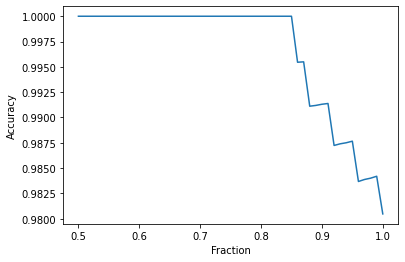

In [9]:
plt.plot(*score)
plt.xlabel("Fraction")
plt.ylabel("Accuracy")

## Try different mask

In [10]:
model.eval()
model = model_builder.build_model(model, dropout_rate=0.5, dropout_mask=DecorrelationMask())

In [11]:
x_batch, y_batch = next(iter(val_loader))
# Calculate uncertainty estimation
estimator = MCDUE(model, num_classes=10, acquisition="bald")
predictions, estimations = estimator(x_batch)

Uncertainty estimation with MCDUE_classification approach: 100%|██████████| 25/25 [00:01<00:00, 18.27it/s]


In [12]:
score = classification_metric(estimations, np.equal(predictions.argmax(axis=-1), y_batch))

Text(0, 0.5, 'Accuracy')

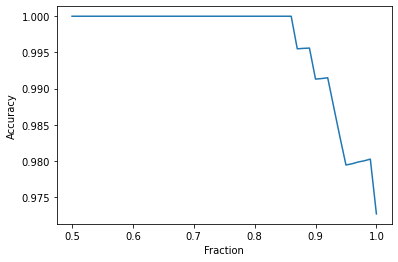

In [13]:
plt.plot(*score)
plt.xlabel("Fraction")
plt.ylabel("Accuracy")